<a href="https://colab.research.google.com/github/MiguelAngeloTr/BIGDATA/blob/main/C1/Clase5AED_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pyspark
!pip install -q findspark

In [3]:
import pandas as pd #No responde con cantidades de datos muy altas
import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.window as W
import pyspark.sql.types as T
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
spark = SparkSession.builder.appName("AED PySpark").getOrCreate()
spark

In [10]:
import requests

path= "https://raw.githubusercontent.com/MiguelAngeloTr/BIGDATA/refs/heads/main/C1/titanic.csv"

# Changed 'request' to 'requests' to call the get method from the imported library
req= requests.get(path)
url_content = req.content

csv_file_name = 'titanic.csv'
csv_file = open(csv_file_name, 'wb')

csv_file.write(url_content)
csv_file.close()

df = spark.read.csv('/content/'+csv_file_name, header=True, inferSchema=True)
df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
|          6|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0|      

In [11]:
df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [12]:
#Viewing the dataframe schema
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [13]:
df.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                NULL|  NULL| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

# Manejo de datos faltantes

In [20]:
def faltantes(df):
  falta = df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns])
  return falta.show()

In [21]:
faltantes(df)

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [24]:
df_f1 = df.drop("Cabin","PassengerId",'Name')
faltantes(df_f1)
print('Shape of the dataset: ', (df_f1.count(), len(df_f1.columns)))

+--------+------+---+---+-----+-----+------+----+--------+
|Survived|Pclass|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|
+--------+------+---+---+-----+-----+------+----+--------+
|       0|     0|  0|177|    0|    0|     0|   0|       2|
+--------+------+---+---+-----+-----+------+----+--------+

Shape of the dataset:  (891, 9)


In [25]:
df_f2 = df_f1.na.drop()
#df_f2 = df_f1.na.fill(0)
faltantes(df_f2)
print('Shape of the dataset: ', (df_f2.count(), len(df_f2.columns)))

+--------+------+---+---+-----+-----+------+----+--------+
|Survived|Pclass|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|
+--------+------+---+---+-----+-----+------+----+--------+
|       0|     0|  0|  0|    0|    0|     0|   0|       0|
+--------+------+---+---+-----+-----+------+----+--------+

Shape of the dataset:  (712, 9)


# Algunas Consultas

## 1. Cuantas personas por clase y lugar de abordaje ingresaron al barco?

In [26]:
res = df_f2.groupby("PClass","Embarked").count().orderBy("Pclass", "Embarked")
window = W.Window.partitionBy("Pclass").orderBy("Embarked")
result = res.withColumn("row", F.row_number().over(window)) \
               .withColumn("Pclass", F.when(F.col("row") == 1, F.col("Pclass")).otherwise(F.lit(""))) \
#               .drop("row")

# Mostrar el resultado
res.show()
#result.show(truncate=False)

+------+--------+-----+
|PClass|Embarked|count|
+------+--------+-----+
|     1|       C|   74|
|     1|       Q|    2|
|     1|       S|  108|
|     2|       C|   15|
|     2|       Q|    2|
|     2|       S|  156|
|     3|       C|   41|
|     3|       Q|   24|
|     3|       S|  290|
+------+--------+-----+



## 2. Cuál es la edad promedio por sexo en cada clase en el barco?

In [30]:
res = df_f2.groupby('Pclass', 'Sex').agg(F.mean('Age').alias('mean_Age')).orderBy('Pclass', 'Sex')
window = W.Window.partitionBy("Pclass").orderBy("Sex")
result = res.withColumn("row", F.row_number().over(window)) \
               .withColumn("Pclass", F.when(F.col("row") == 1, F.col("Pclass")).otherwise(F.lit(""))) \
               .drop("row")
result.show(truncate=False) # las personas de mayor edad estan en la clase uno

+------+------+------------------+
|Pclass|Sex   |mean_Age          |
+------+------+------------------+
|1     |female|34.24096385542169 |
|      |male  |41.28138613861386 |
|2     |female|28.722972972972972|
|      |male  |30.74070707070707 |
|3     |female|21.75             |
|      |male  |26.507588932806325|
+------+------+------------------+



## 3. Cuál es el costo promedio del tiquete por sexo en cada clase en el barco?

In [29]:
res = df_f2.groupby('Pclass', 'Sex').agg(F.mean('Fare').alias('mean_Fare')).orderBy('Pclass', 'Sex')
window = W.Window.partitionBy("Pclass").orderBy("Sex")
result = res.withColumn("row", F.row_number().over(window)) \
               .withColumn("Pclass", F.when(F.col("row") == 1, F.col("Pclass")).otherwise(F.lit(""))) \
               .drop("row")
result.show(truncate=False) #En promedio la clases el costo de las mujeres


+------+------+------------------+
|Pclass|Sex   |mean_Fare         |
+------+------+------------------+
|1     |female|108.61967951807229|
|      |male  |71.14278118811883 |
|2     |female|21.951070270270268|
|      |male  |21.113131313131312|
|3     |female|15.875368627450975|
|      |male  |12.162695256917003|
+------+------+------------------+



# Recodificación de Variables

## Creación de una variable Age_class, la cual a partir de la columna edad existente se obtenga una variable a partir de rangos de edad

In [31]:
def age_condition(x):
    if x<18:
        return "18-"
    elif 18 <= x <= 25:
        return "18-25"
    elif 25 <= x <= 34:
        return "25-34"
    elif 35 <= x <= 44:
        return "35-44"
    elif 45 <= x <= 54:
        return "45-54"
    else:
        return "55+"

In [33]:
age_udf = F.udf(lambda x: age_condition(x), T.StringType()) #udf para colocar una función
df_f3 = df_f2.withColumn("age_class", age_udf("Age"))
df_f3.show(5) #genera una columna para describir el rango en que se encuentra la edad #puede servir para generar histogramas del rango de edad

+--------+------+------+----+-----+-----+----------------+-------+--------+---------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|age_class|
+--------+------+------+----+-----+-----+----------------+-------+--------+---------+
|       0|     3|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|    18-25|
|       1|     1|female|38.0|    1|    0|        PC 17599|71.2833|       C|    35-44|
|       1|     3|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|    25-34|
|       1|     1|female|35.0|    1|    0|          113803|   53.1|       S|    35-44|
|       0|     3|  male|35.0|    0|    0|          373450|   8.05|       S|    35-44|
+--------+------+------+----+-----+-----+----------------+-------+--------+---------+
only showing top 5 rows



## 4. Realice de forma detallada por rango de edad, cuantas personas ingresaron en el barco y que porcentaje representan. Ademas, cual fue el costo máximo, mínimo y promedio de los tiquetes en cada caso

In [34]:
window = W.Window.rowsBetween(W.Window.unboundedPreceding,W.Window.unboundedFollowing) #considero todos los valores
tab = df_f3.select(['age_class','Fare']).\
      groupBy('age_class').\
      agg(F.count('Fare').alias('Quantity'),
      F.mean('Fare').alias('Fare_avg'),
      F.min('Fare').alias('Fare_min'),
      F.max('Fare').alias('Fare_max')).\
      withColumn('Total',F.sum(F.col('Quantity')).over(window)).\
      withColumn('Percent',F.col('Quantity')*100/F.col('Total')).\
      drop(F.col('Total')).orderBy("age_class")
tab.show()

+---------+--------+------------------+--------+--------+------------------+
|age_class|Quantity|          Fare_avg|Fare_min|Fare_max|           Percent|
+---------+--------+------------------+--------+--------+------------------+
|      18-|     113| 31.22079823008851|  7.0542|211.3375|15.870786516853933|
|    18-25|     188| 30.35658138297874|     0.0|   263.0| 26.40449438202247|
|    25-34|     177|24.757248022598876|     5.0|   211.5|24.859550561797754|
|    35-44|     119|50.794221008403376|     0.0|512.3292|16.713483146067414|
|    45-54|      73|43.153201369863005|     0.0|247.5208|10.252808988764045|
|      55+|      42| 42.86110952380953|  6.2375|   263.0| 5.898876404494382|
+---------+--------+------------------+--------+--------+------------------+



## ¿Como la tabla anterior podría ser desagregada por clase (primera, segunda y tercera clase)?

# Gráficos: Cajas e Histogramas

+-------------------+-----------------+
|      skewness(Age)|    kurtosis(Age)|
+-------------------+-----------------+
|0.38828985146986594|0.168636572242868|
+-------------------+-----------------+



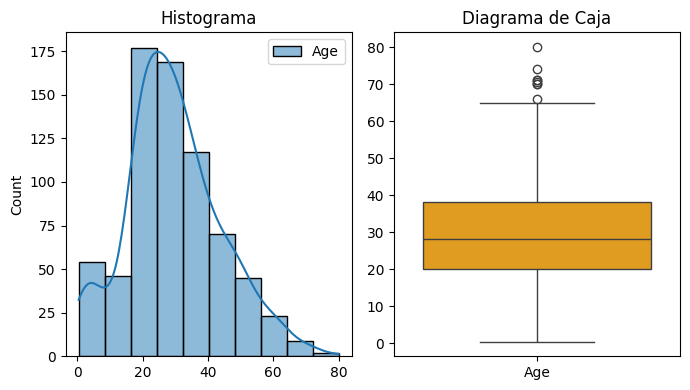

In [37]:
df_Age = df_f2.select('Age').toPandas()
df.select(F.skewness('Age'),F.kurtosis('Age')).show()
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_Age, kde=True, bins=10, color='blue')
plt.title('Histograma')

# Diagrama de caja (boxplot)
plt.subplot(1, 2, 2)
sns.boxplot(df_Age, color='orange')
plt.title('Diagrama de Caja')

# Mostrar los gráficos
plt.tight_layout()
plt.show()
#La distribucion tiene una concentracion entre 20 y 40 años
#No hay mucha dispersión
#Hay mucha dispersión de los datos atipicos


+-----------------+-----------------+
|   skewness(Fare)|   kurtosis(Fare)|
+-----------------+-----------------+
|4.779253292372357|33.20428925264468|
+-----------------+-----------------+



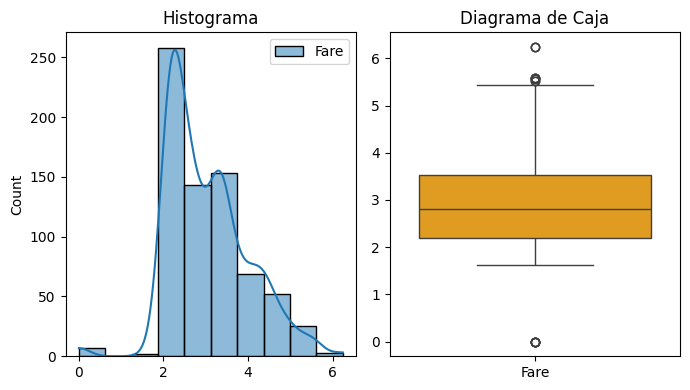

In [38]:
df_Fare = np.log1p(df_f2.select('Fare').toPandas()) #Ajusta la escala por que una funcion logaritmica es mas facil de visualizar
df.select(F.skewness('Fare'),F.kurtosis('Fare')).show()
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_Fare, kde=True, bins=10, color='blue')
plt.title('Histograma')

plt.subplot(1, 2, 2)
sns.boxplot(df_Fare, color='orange')
plt.title('Diagrama de Caja')

plt.tight_layout()
plt.show()
#Cantidad / Precio
#El valor promedio se encuentra entre
#Esta concentrado a los valores mas economicos
#Asimetria en los datos


## Cual fue el costo del tiquete en relacion a la clase en el barco?

<Axes: xlabel='Pclass', ylabel='Fare'>

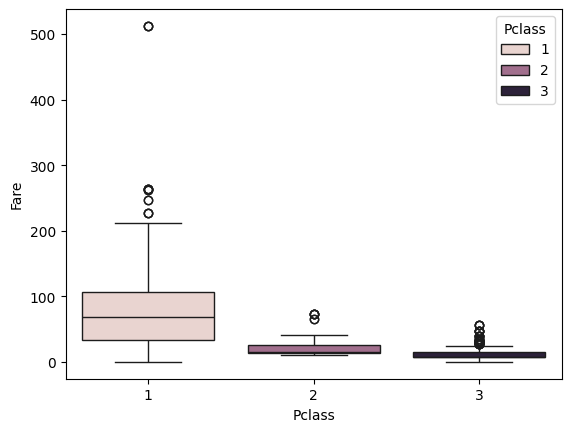

In [40]:
df_class_fare = df_f2.select('Pclass','Fare').toPandas()
sns.boxplot(x='Pclass', y='Fare', data=df_class_fare, hue='Pclass')

#Dice que mayor diferencia generan entre
#Los valores de la clase uno estan mas orientadas hacia

#La clase 2 tiene gran asimetria
#La clase 3 es la menos dispersa, tiene menos asimetria


## Cual fue la proporción de hombres y mujeres en el barco?

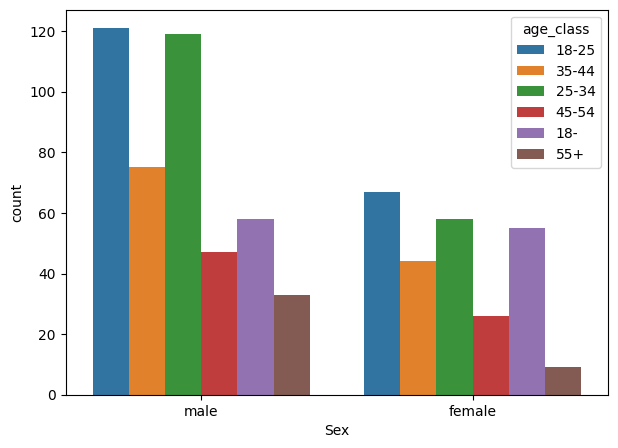

In [41]:
df_Sex = df_f3.select('Sex','age_class').toPandas()
plt.figure(figsize=(7, 5))
sns.countplot(x='Sex', data=df_Sex, hue='age_class')
plt.show()



## Existe alguna relación entre la edad y el costo del tiquete para el pasajero?

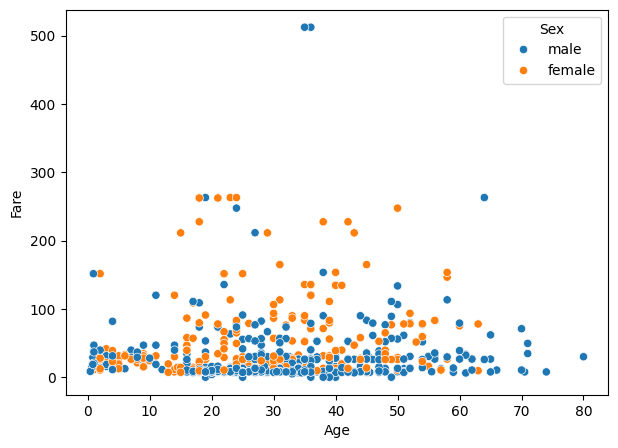

In [42]:
df_fare = df_f2.select('Age','Fare','Sex').toPandas()
plt.figure(figsize=(7, 5))
sns.scatterplot(x='Age', y='Fare', data=df_fare, hue='Sex')
plt.show()
#No hay una relación fuerte entre el precio y la edad

## Que variables tuvieron relación con la superviviencia de las personas en el barco?

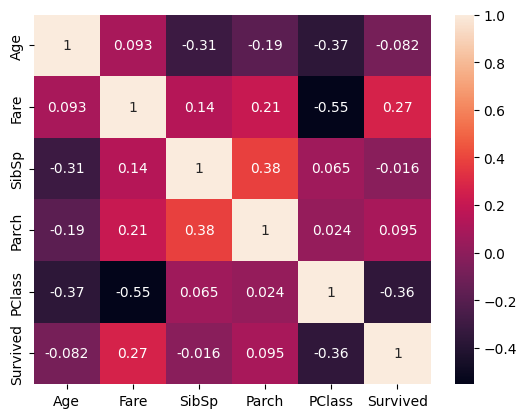

In [43]:
df_full = df_f2.select('Age','Fare','SibSp','Parch','PClass','Survived').toPandas()
sns.heatmap(df_full.corr(), annot=True)
plt.show()